In [1]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from transformers import ConvNextForImageClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
# Підготовка датасету
data_dir = r'C:\Users\Demyd Zaborskyi\.cache\kagglehub\datasets\itsahmad\indoor-scenes-cvpr-2019\versions\1\indoorCVPR_09\Images'

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Середні та STD для ImageNet
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)

train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

batch_size = 32

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

num_classes = len(full_dataset.classes)
print(f"Number of classes: {num_classes}")

Number of classes: 67


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("GPU not available. Using CPU.")

class_names = full_dataset.classes


Using GPU: NVIDIA GeForce RTX 4070


In [4]:
# Завантаження моделі ConvNeXt для Dynamic Multiscale Adapter
model_name = 'facebook/convnext-base-224'
model_dynamic = ConvNextForImageClassification.from_pretrained(model_name)
model_dynamic.classifier = nn.Linear(model_dynamic.classifier.in_features, num_classes)

# Завантаження моделі ConvNeXt для Adapter Tuning
model_adapter_base = ConvNextForImageClassification.from_pretrained(model_name)
model_adapter_base.classifier = nn.Linear(model_adapter_base.classifier.in_features, num_classes)


In [5]:
# Визначення класу Adapter
class Adapter(nn.Module):
    def __init__(self, input_dim, adapter_dim=64):
        super(Adapter, self).__init__()
        self.adapter = nn.Sequential(
            nn.Conv2d(input_dim, adapter_dim, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(adapter_dim, input_dim, kernel_size=1)
        )

    def forward(self, x):
        return x + self.adapter(x)
    

# Визначення класу Dynamic Multiscale Adapter
class DynamicMultiscaleAdapter(nn.Module):
    def __init__(self, input_dim, adapter_dim=64, scales=[1, 2, 3]):
        super(DynamicMultiscaleAdapter, self).__init__()
        self.scales = scales
        self.adapters = nn.ModuleList()
        for scale in scales:
            self.adapters.append(nn.Sequential(
                nn.Conv2d(input_dim, adapter_dim, kernel_size=1),
                nn.ReLU(),
                nn.Conv2d(adapter_dim, input_dim, kernel_size=1)
            ))
        self.gate = nn.Linear(input_dim, len(scales))

    def forward(self, x):
        gap = x.mean(dim=[2, 3])
        gate_weights = self.gate(gap)
        gate_weights = torch.softmax(gate_weights, dim=-1)

        adapter_outputs = []
        for i, adapter in enumerate(self.adapters):
            if self.scales[i] != 1:
                scale = self.scales[i]
                x_resized = nn.functional.interpolate(
                    x, scale_factor=1/scale, mode='bilinear', align_corners=False
                )
                x_resized = adapter(x_resized)
                x_resized = nn.functional.interpolate(
                    x_resized, size=x.shape[2:], mode='bilinear', align_corners=False
                )
            else:
                x_resized = adapter(x)
            adapter_outputs.append(x_resized)

        adapter_outputs = torch.stack(adapter_outputs, dim=0)
        gate_weights = gate_weights.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        gate_weights = gate_weights.permute(1, 0, 2, 3, 4)
        x_adapted = (adapter_outputs * gate_weights).sum(dim=0)

        return x + x_adapted
    
# Визначення обгорнутих блоків з адаптерами
class BlockWithAdapter(nn.Module):
    def __init__(self, block, adapter):
        super(BlockWithAdapter, self).__init__()
        self.block = block
        self.adapter = adapter

    def forward(self, x):
        x = self.block(x)
        x = self.adapter(x)
        return x
    
class BlockWithDynamicAdapter(nn.Module):
    def __init__(self, block, adapter):
        super(BlockWithDynamicAdapter, self).__init__()
        self.block = block
        self.adapter = adapter

    def forward(self, x):
        x = self.block(x)
        x = self.adapter(x)
        return x
    
class ConvNextWithAdapters(nn.Module):
    def __init__(self, base_model, adapter_dim=64):
        super(ConvNextWithAdapters, self).__init__()
        self.base_model = base_model
        self.num_classes = base_model.classifier.out_features

        for stage in self.base_model.convnext.encoder.stages:
            for idx, layer in enumerate(stage.layers):
                input_dim = layer.layernorm.normalized_shape[0]
                adapter = Adapter(input_dim, adapter_dim).to(device)
                layer_with_adapter = BlockWithAdapter(layer, adapter)
                stage.layers[idx] = layer_with_adapter

        # Ensure ConvNextLayerNorm is used
        from transformers.models.convnext.modeling_convnext import ConvNextLayerNorm

        # Виправлення normalized_shape
        normalized_shape = self.base_model.convnext.layernorm.normalized_shape
        if isinstance(normalized_shape[0], tuple):
            normalized_shape = normalized_shape[0]

        self.base_model.convnext.layernorm = ConvNextLayerNorm(
            normalized_shape=normalized_shape,
            eps=self.base_model.convnext.layernorm.eps,
            data_format='channels_first'  # Встановлюємо data_format
        )

        for name, param in self.base_model.named_parameters():
            if 'adapter' in name or 'classifier' in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

    def forward(self, x):
        embedding_output = self.base_model.convnext.embeddings(x)
        encoder_outputs = self.base_model.convnext.encoder(embedding_output)
        last_hidden_state = encoder_outputs[0]  # Отримуємо тензор
        last_hidden_state = self.base_model.convnext.layernorm(last_hidden_state)
        # Apply global average pooling
        pooled_output = last_hidden_state.mean(dim=[2, 3])  # Global average pooling
        logits = self.base_model.classifier(pooled_output)
        return logits
    
class ConvNextWithDynamicAdapter(nn.Module):
    def __init__(self, base_model, adapter_dim=64, scales=[1, 2, 3]):
        super(ConvNextWithDynamicAdapter, self).__init__()
        self.base_model = base_model
        self.num_classes = base_model.classifier.out_features

        for stage in self.base_model.convnext.encoder.stages:
            for idx, layer in enumerate(stage.layers):
                input_dim = layer.layernorm.normalized_shape[0]
                adapter = DynamicMultiscaleAdapter(
                    input_dim, adapter_dim, scales
                ).to(device)
                layer_with_adapter = BlockWithDynamicAdapter(layer, adapter)
                stage.layers[idx] = layer_with_adapter

        # Ensure ConvNextLayerNorm is used
        from transformers.models.convnext.modeling_convnext import ConvNextLayerNorm

        # Виправлення normalized_shape
        normalized_shape = self.base_model.convnext.layernorm.normalized_shape
        if isinstance(normalized_shape[0], tuple):
            normalized_shape = normalized_shape[0]

        self.base_model.convnext.layernorm = ConvNextLayerNorm(
            normalized_shape=normalized_shape,
            eps=self.base_model.convnext.layernorm.eps,
            data_format='channels_first'  # Встановлюємо data_format
        )

        # Freeze parameters except adapters and classifier
        for name, param in self.base_model.named_parameters():
            if 'adapter' in name or 'dynamic_adapter' in name or 'classifier' in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

    def forward(self, x):
        embedding_output = self.base_model.convnext.embeddings(x)
        encoder_outputs = self.base_model.convnext.encoder(embedding_output)
        last_hidden_state = encoder_outputs[0]
        last_hidden_state = self.base_model.convnext.layernorm(last_hidden_state)
        # Apply global average pooling
        pooled_output = last_hidden_state.mean(dim=[2, 3])  # Global average pooling
        logits = self.base_model.classifier(pooled_output)
        return logits

In [6]:
# Ініціалізація моделей
adapter_dim = 64
scales = [1, 2, 3]

# Модель з Dynamic Multiscale Adapter
model_dynamic_adapter = ConvNextWithDynamicAdapter(
    model_dynamic, adapter_dim=adapter_dim, scales=scales
)
model_dynamic_adapter.to(device)

# Модель з Adapter Tuning
model_adapter = ConvNextWithAdapters(
    model_adapter_base, adapter_dim=adapter_dim
)
model_adapter.to(device)

ConvNextWithAdapters(
  (base_model): ConvNextForImageClassification(
    (convnext): ConvNextModel(
      (embeddings): ConvNextEmbeddings(
        (patch_embeddings): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
        (layernorm): ConvNextLayerNorm()
      )
      (encoder): ConvNextEncoder(
        (stages): ModuleList(
          (0): ConvNextStage(
            (downsampling_layer): Identity()
            (layers): Sequential(
              (0): BlockWithAdapter(
                (block): ConvNextLayer(
                  (dwconv): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
                  (layernorm): ConvNextLayerNorm()
                  (pwconv1): Linear(in_features=128, out_features=512, bias=True)
                  (act): GELUActivation()
                  (pwconv2): Linear(in_features=512, out_features=128, bias=True)
                  (drop_path): Identity()
                )
                (adapter): Adapter(
                  (ad

In [7]:
# Налаштування оптимізаторів та критеріїв
criterion_dynamic = nn.CrossEntropyLoss()
optimizer_dynamic = optim.AdamW(
    filter(lambda p: p.requires_grad, model_dynamic_adapter.parameters()),
    lr=1e-4,
    weight_decay=1e-4
)

criterion_adapter = nn.CrossEntropyLoss()
optimizer_adapter = optim.AdamW(
    filter(lambda p: p.requires_grad, model_adapter.parameters()),
    lr=1e-4,
    weight_decay=1e-4
)


In [8]:
import warnings
warnings.filterwarnings("ignore", message="Some weights of the model checkpoint")

def train_model(model, train_loader, val_loader, criterion, optimizer,
                device, num_epochs=10, model_name='model'):
    best_val_acc = 0.0
    total_training_time = 0.0

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            logits = outputs

            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total

        # Валідація
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                logits = outputs

                loss = criterion(logits, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(logits, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / val_total

        end_time = time.time()
        epoch_time = end_time - start_time
        total_training_time += epoch_time

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | "
              f"Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f} | "
              f"Time: {epoch_time:.2f}s")

        # Збереження найкращої моделі
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            torch.save(model.state_dict(), f'best_{model_name}.pth')

    print(f"Best Validation Accuracy for {model_name}: {best_val_acc:.4f}")
    print(f"Total Training Time for {model_name}: {total_training_time:.2f}s")
    return total_training_time

def evaluate_model(model, test_loader, device, class_names, model_name='model'):
    model.eval()
    all_preds = []
    all_labels = []
    inference_times = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            start_time = time.time()
            outputs = model(inputs)
            logits = outputs
            end_time = time.time()

            _, preds = torch.max(logits, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            inference_times.append(end_time - start_time)

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(
        all_labels, all_preds, average='weighted', zero_division=0
    )
    recall = recall_score(
        all_labels, all_preds, average='weighted', zero_division=0
    )
    f1 = f1_score(
        all_labels, all_preds, average='weighted', zero_division=0
    )
    avg_inference_time = sum(inference_times) / len(inference_times)

    print(f"\nTest Metrics for {model_name}:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=class_names, yticklabels=class_names
    )
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    return acc, precision, recall, f1, avg_inference_time, cm

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad
    )
    return total_params, trainable_params

In [9]:
print("\n=== Training model with Dynamic Multiscale Adapter ===")
training_time_dynamic = train_model(
    model=model_dynamic_adapter,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion_dynamic,
    optimizer=optimizer_dynamic,
    device=device,
    num_epochs=10,
    model_name='model_dynamic_adapter_convnext'
)


=== Training model with Dynamic Multiscale Adapter ===
Epoch 1/10 | Train Loss: 3.5544 | Train Acc: 0.1216 | Val Loss: 2.8763 | Val Acc: 0.2702 | Time: 248.21s
Epoch 2/10 | Train Loss: 2.2175 | Train Acc: 0.3958 | Val Loss: 1.8119 | Val Acc: 0.4895 | Time: 254.69s
Epoch 3/10 | Train Loss: 1.3449 | Train Acc: 0.6173 | Val Loss: 1.3505 | Val Acc: 0.6172 | Time: 263.93s
Epoch 4/10 | Train Loss: 0.9124 | Train Acc: 0.7384 | Val Loss: 1.1402 | Val Acc: 0.6714 | Time: 260.51s
Epoch 5/10 | Train Loss: 0.6263 | Train Acc: 0.8217 | Val Loss: 1.0180 | Val Acc: 0.7012 | Time: 252.29s
Epoch 6/10 | Train Loss: 0.4255 | Train Acc: 0.8811 | Val Loss: 0.9709 | Val Acc: 0.7234 | Time: 254.82s
Epoch 7/10 | Train Loss: 0.2547 | Train Acc: 0.9370 | Val Loss: 0.9624 | Val Acc: 0.7307 | Time: 279.22s
Epoch 8/10 | Train Loss: 0.1725 | Train Acc: 0.9576 | Val Loss: 1.0124 | Val Acc: 0.7175 | Time: 269.78s
Epoch 9/10 | Train Loss: 0.1312 | Train Acc: 0.9703 | Val Loss: 1.0881 | Val Acc: 0.7081 | Time: 242.88s


=== Evaluating model with Custom Adapter ===

Test Metrics for Dynamic Multiscale Adapter:
Accuracy: 0.7431
Precision: 0.7591
Recall: 0.7431
F1-Score: 0.7413


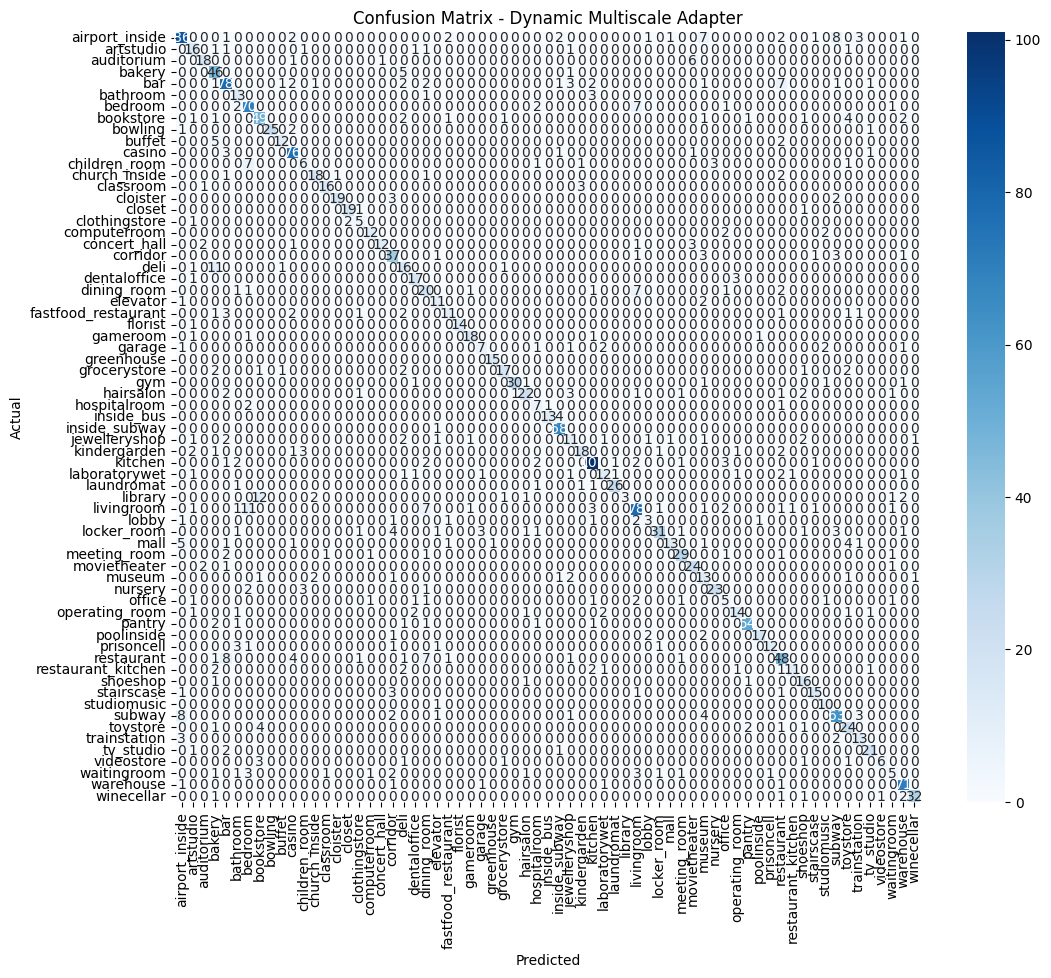


Dynamic Multiscale Adapter Model - Total Parameters: 94680879, Trainable Parameters: 7114415


In [10]:
print("\n=== Evaluating model with Custom Adapter ===")
model_dynamic_adapter.load_state_dict(torch.load('best_model_dynamic_adapter_convnext.pth'))
model_dynamic_adapter.to(device)
acc_dynamic_adapter, precision_dynamic_adapter, recall_dynamic_adapter, f1_dynamic_adapter, inference_time_dynamic_adapter, cm_dynamic_adapter = evaluate_model(
    model=model_dynamic_adapter,
    test_loader=test_loader,
    device=device,
    class_names=class_names,
    model_name='Dynamic Multiscale Adapter'
)

total_params_dynamic_adapter, trainable_params_dynamic_adapter = count_parameters(model_dynamic_adapter)
print(f"\nDynamic Multiscale Adapter Model - Total Parameters: {total_params_dynamic_adapter}, Trainable Parameters: {trainable_params_dynamic_adapter}")


In [11]:
print("\n=== Training model with Adapter Tuning ===")
training_time_adapter = train_model(
    model=model_adapter,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion_adapter,
    optimizer=optimizer_adapter,
    device=device,
    num_epochs=10,
    model_name='model_adapter_convnext'
)



=== Training model with Adapter Tuning ===
Epoch 1/10 | Train Loss: 3.4390 | Train Acc: 0.1621 | Val Loss: 2.4761 | Val Acc: 0.3747 | Time: 98.89s
Epoch 2/10 | Train Loss: 1.9057 | Train Acc: 0.4888 | Val Loss: 1.6419 | Val Acc: 0.5711 | Time: 101.30s
Epoch 3/10 | Train Loss: 1.2577 | Train Acc: 0.6508 | Val Loss: 1.2145 | Val Acc: 0.6620 | Time: 100.71s
Epoch 4/10 | Train Loss: 0.9301 | Train Acc: 0.7361 | Val Loss: 1.1318 | Val Acc: 0.6697 | Time: 102.08s
Epoch 5/10 | Train Loss: 0.7137 | Train Acc: 0.7950 | Val Loss: 0.9805 | Val Acc: 0.7115 | Time: 103.20s
Epoch 6/10 | Train Loss: 0.5536 | Train Acc: 0.8460 | Val Loss: 0.9992 | Val Acc: 0.7004 | Time: 98.64s
Epoch 7/10 | Train Loss: 0.4235 | Train Acc: 0.8851 | Val Loss: 0.8884 | Val Acc: 0.7286 | Time: 103.04s
Epoch 8/10 | Train Loss: 0.3186 | Train Acc: 0.9159 | Val Loss: 0.9449 | Val Acc: 0.7226 | Time: 100.95s
Epoch 9/10 | Train Loss: 0.2386 | Train Acc: 0.9393 | Val Loss: 0.9429 | Val Acc: 0.7337 | Time: 99.38s
Epoch 10/10 | 


=== Evaluating model with Adapter Tuning ===

Test Metrics for Adapter Tuning:
Accuracy: 0.7738
Precision: 0.7851
Recall: 0.7738
F1-Score: 0.7724


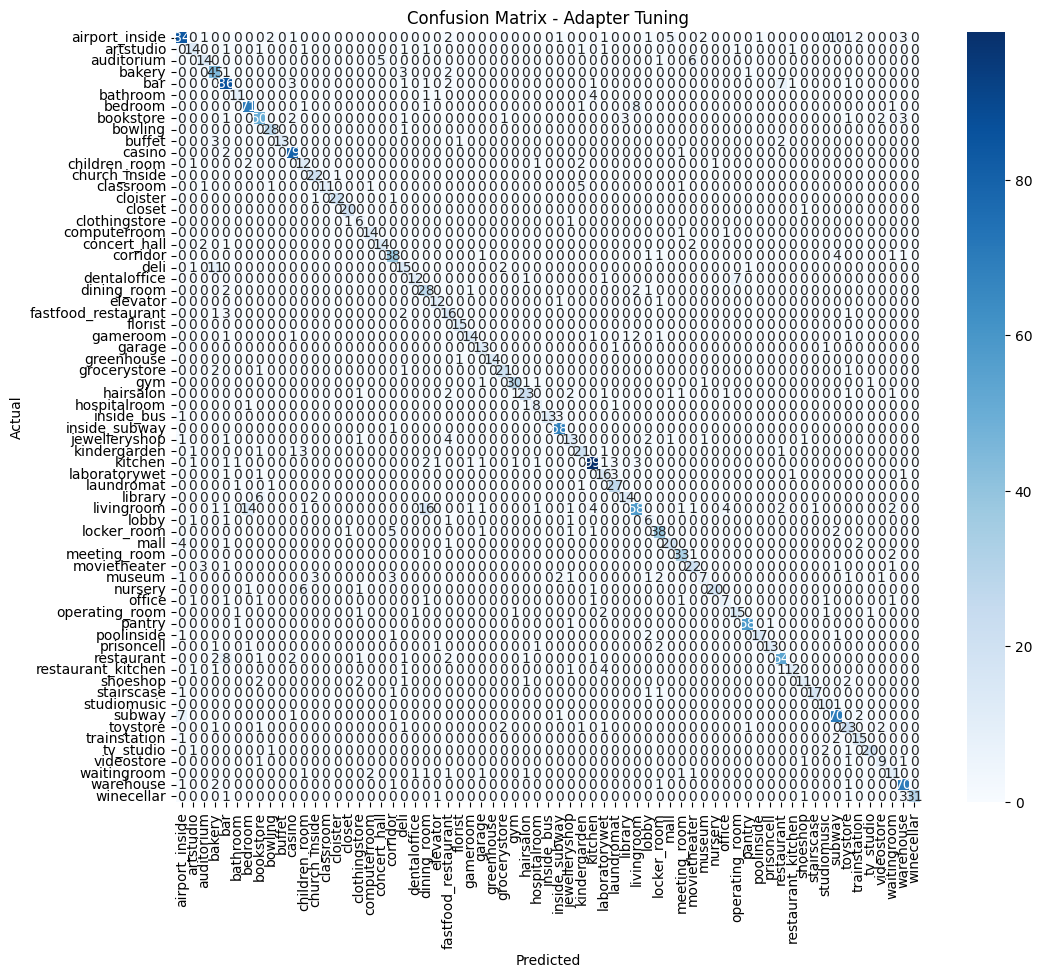


Adapter Tuning Model - Total Parameters: 89965635, Trainable Parameters: 2399171


In [15]:
print("\n=== Evaluating model with Adapter Tuning ===")
model_adapter.load_state_dict(torch.load('best_model_adapter_convnext.pth'))
model_adapter.to(device)
acc_adapter, precision_adapter, recall_adapter, f1_adapter, inference_time_adapter, cm_adapter = evaluate_model(
    model=model_adapter,
    test_loader=test_loader,
    device=device,
    class_names=class_names,
    model_name='Adapter Tuning'
)

total_params_adapter, trainable_params_adapter = count_parameters(model_adapter)
print(f"\nAdapter Tuning Model - Total Parameters: {total_params_adapter}, Trainable Parameters: {trainable_params_adapter}")


In [16]:
data = {
    'Model': ['Dynamic Multiscale Adapter', 'Adapter Tuning'],
    'Accuracy': [acc_dynamic_adapter, acc_adapter],
    'Precision': [precision_dynamic_adapter, precision_adapter],
    'Recall': [recall_dynamic_adapter, recall_adapter],
    'F1-Score': [f1_dynamic_adapter, f1_adapter],
    'Training Time (s)': [training_time_dynamic, training_time_adapter],
    'Inference Time (s)': [inference_time_dynamic_adapter, inference_time_adapter],
    'Total Params': [total_params_dynamic_adapter, total_params_adapter],
    'Trainable Params': [trainable_params_dynamic_adapter, trainable_params_adapter],
}

df_results = pd.DataFrame(data)
print("\nPEFT Comparative Analysis:")
print(df_results)



PEFT Comparative Analysis:
                        Model  Accuracy  Precision    Recall  F1-Score  \
0  Dynamic Multiscale Adapter  0.743064   0.759142  0.743064  0.741316   
1              Adapter Tuning  0.773794   0.785055  0.773794  0.772413   

   Training Time (s)  Inference Time (s)  Total Params  Trainable Params  
0        2580.092314            0.020924      94680879           7114415  
1        1006.815825            0.010049      89965635           2399171  
